# HVAC anomaly detection model

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import boto3

from sagemaker import get_execution_role

from common import dataManagement
from db import hvacDBMapping

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import HTML
from IPython.display import Image

## Introduction

This notebook will be used to train and deploy an anomaly detection model for the Thermafuser component of and HVAC system. The thermafuser component is the terminal or endpoint of an HVAC system and its from where the room guests get the cool air. We are tasked with detecting anomalies in the system by training a ML on unlabeled data.

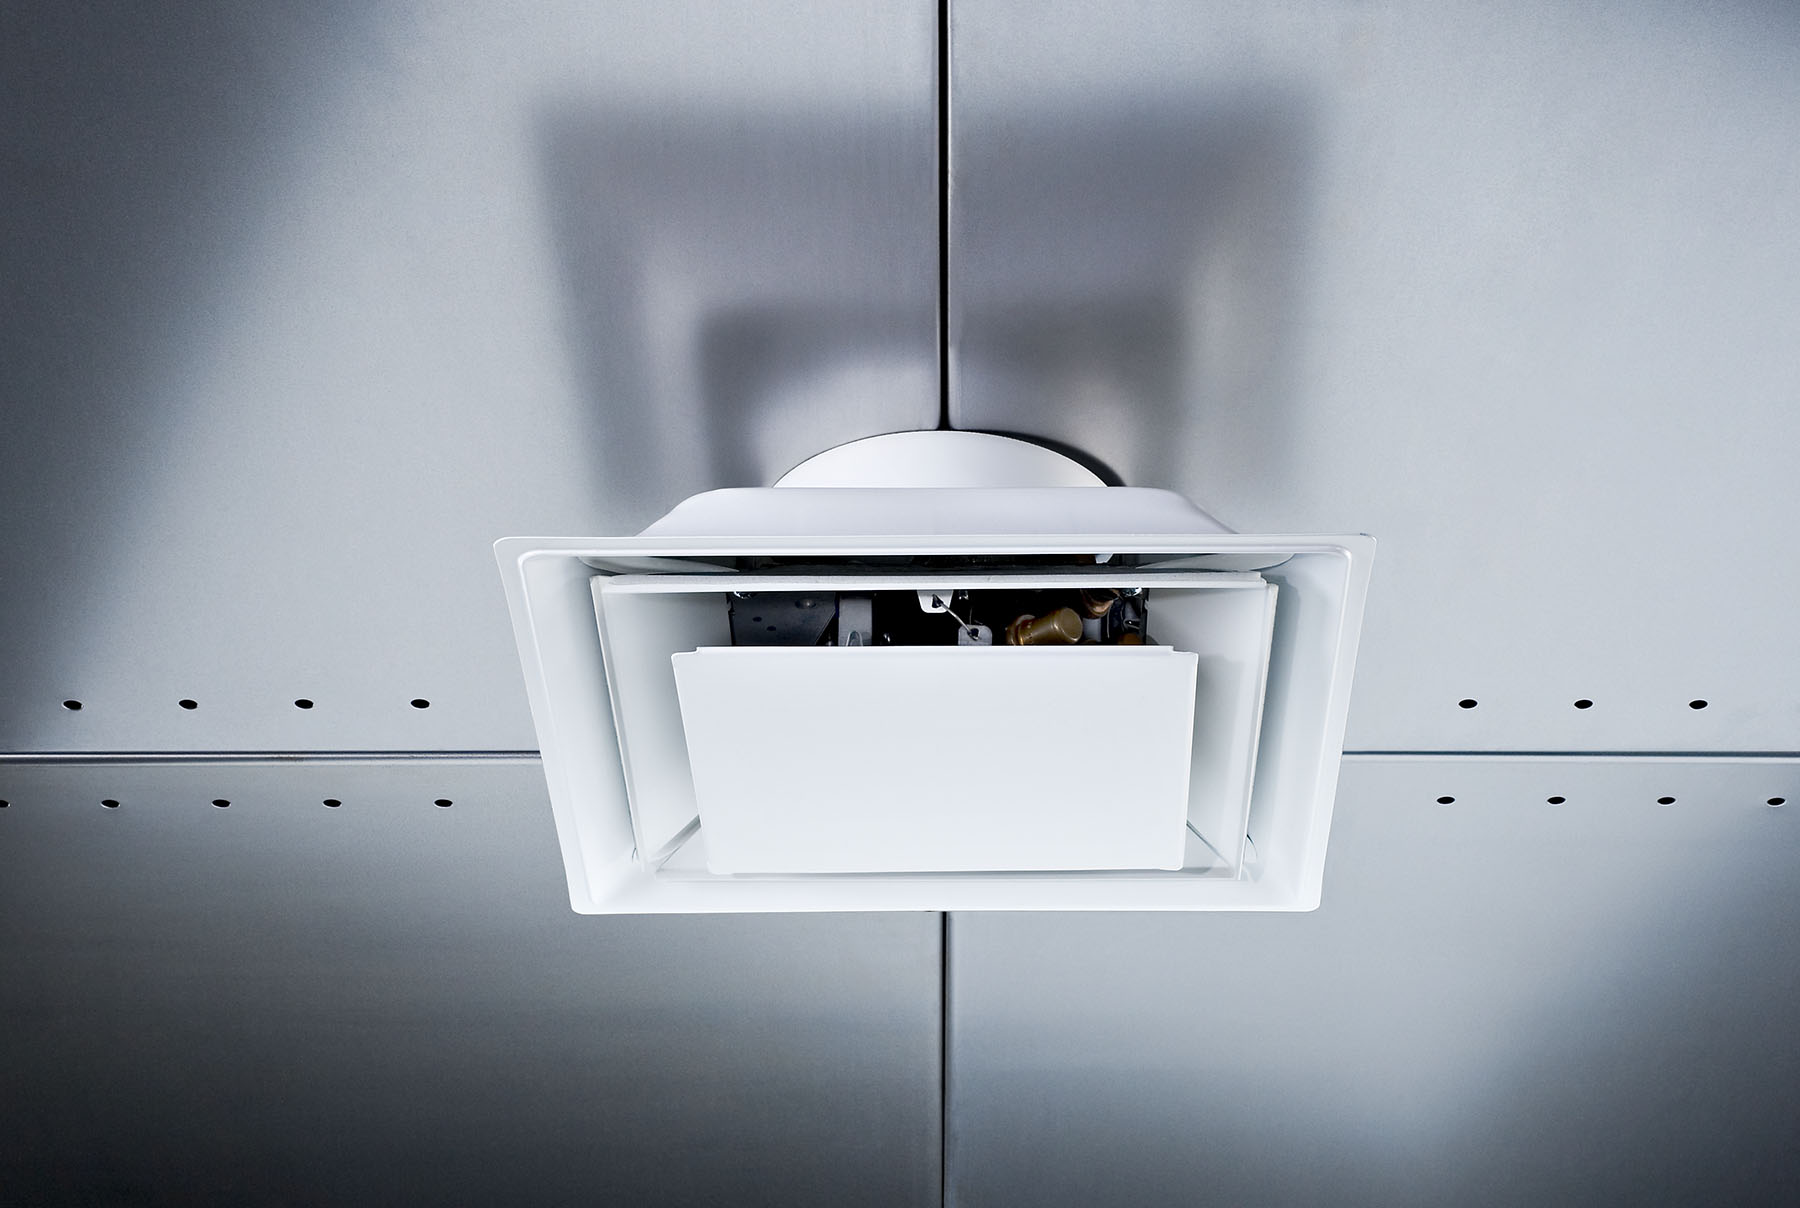

In [2]:
Image(filename='imgs/thermafuser1.jpg')

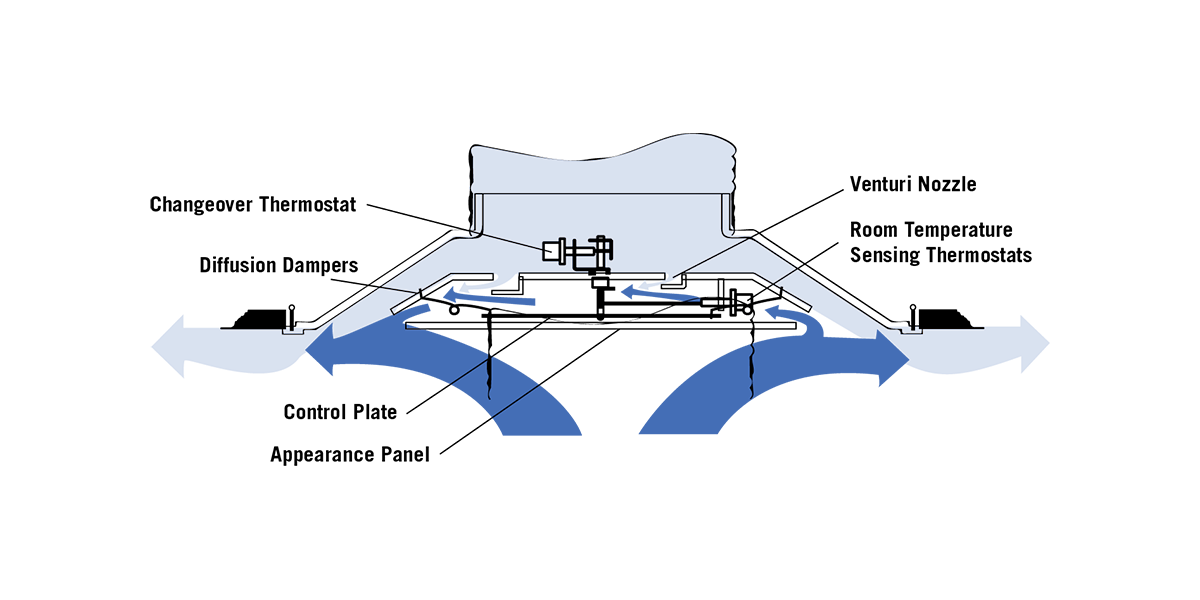

In [3]:
Image(filename='imgs/thermafuser2.png')

## About the data

This dataset contains around 3 months of readings for 5 different thermafusers placed in 5 different rooms in a schhol building in the central Valley of California. 

## Features
### Data columns

* thermafuserId: Integer - The Id of the thermafuser being read
* roomOccupied: Boolean - Indicates wheter the occupier sensors of the thermafuser were on or off
* supplyAir: Float - The temperatue of the air being supplied by the thermafuser
* timestamp: Datetime - The datetime when the reading was made
* occupiedCoolingSetpoint: Float - The setpoint at which the thermafuser starts letting cool air into the room
* terminalLoad: Float 	
* zoneTemperature: Float - The temperature of the room as measured by the room sensing thermostats	
* airflowFeedback: Float	
* occupiedHeatingSetpoint: Float - The setpoint at which the thermafuser starts letting warm air into the room

## Data pre-processing and analysis

In [4]:
role = get_execution_role()
print(role)
bucket='octank-america-sagemaker-resources'
train_prefix = 'training'
data_key = 'thermafuser_readings.csv'
data_location = 's3://{}/{}/{}'.format(bucket, train_prefix, data_key)

arn:aws:iam::153918162224:role/service-role/AmazonSageMakerServiceCatalogProductsUseRole


In [5]:
thermafuser_df_backup = pd.read_csv(data_location, low_memory=False, index_col=False)
thermafuser_df_backup.head()

,Unnamed: 0,_thermafuserId,_roomOccupied,_supplyAir,_timestamp,_occupiedCoolingSetpoint,_terminalLoad,_zoneTemperature,_airflowFeedback,_occupiedHeatingSetpoint
0,0,1,True,75.199997,2018-07-11 14:15:00,76.0,NaN,74.699997,63.0,70.0
1,1,2,True,76.400002,2018-07-11 14:15:00,76.0,NaN,76.400002,21.0,70.0
2,2,3,True,75.699997,2018-07-11 14:15:00,76.0,NaN,76.800003,21.0,70.0
3,3,4,True,68.900002,2018-07-11 14:15:00,76.0,NaN,76.500000,82.0,70.0
4,4,5,True,57.799999,2018-07-11 14:15:00,72.0,NaN,71.699997,69.0,70.0


In [6]:
thermafuser_df = thermafuser_df_backup.copy(deep=True)
thermafuser_df = thermafuser_df.drop('Unnamed: 0', axis=1)
thermafuser_df = thermafuser_df.loc[thermafuser_df['_thermafuserId'] == 1]
thermafuser_df.reset_index(inplace=True, drop=True)

In [7]:
thermafuser_df.head()

,_thermafuserId,_roomOccupied,_supplyAir,_timestamp,_occupiedCoolingSetpoint,_terminalLoad,_zoneTemperature,_airflowFeedback,_occupiedHeatingSetpoint
0,1,True,75.199997,2018-07-11 14:15:00,76.0,NaN,74.699997,63.0,70.0
1,1,True,76.099998,2018-07-11 14:20:01,76.0,NaN,74.300003,61.0,70.0
2,1,True,75.900002,2018-07-11 14:25:01,76.0,NaN,74.900002,59.0,70.0
3,1,True,75.900002,2018-07-11 14:30:02,76.0,NaN,75.099998,76.0,70.0
4,1,True,75.699997,2018-07-11 14:35:04,76.0,NaN,75.599998,150.0,70.0


In [8]:
col_names = {'_roomOccupied':'RoomOccupied', '_supplyAir':'SupplyAir', 
             '_occupiedCoolingSetpoint':'OccupiedCoolingSetpoint', '_terminalLoad':'TerminalLoad', 
            '_zoneTemperature':'ZoneTemperature', '_airflowFeedback':'AirflowFeedback', 
            '_occupiedHeatingSetpoint':'OccupiedHeatingSetpoint', '_timestamp':'Timestamp'}

thermafuser_df = thermafuser_df.drop('_thermafuserId', axis=1)
thermafuser_df = thermafuser_df.rename(columns=col_names)

In [9]:
thermafuser_df['Timestamp'] = pd.to_datetime(thermafuser_df['Timestamp'])
thermafuser_df.head()

,RoomOccupied,SupplyAir,Timestamp,OccupiedCoolingSetpoint,TerminalLoad,ZoneTemperature,AirflowFeedback,OccupiedHeatingSetpoint
0,True,75.199997,2018-07-11 14:15:00,76.0,NaN,74.699997,63.0,70.0
1,True,76.099998,2018-07-11 14:20:01,76.0,NaN,74.300003,61.0,70.0
2,True,75.900002,2018-07-11 14:25:01,76.0,NaN,74.900002,59.0,70.0
3,True,75.900002,2018-07-11 14:30:02,76.0,NaN,75.099998,76.0,70.0
4,True,75.699997,2018-07-11 14:35:04,76.0,NaN,75.599998,150.0,70.0


In [10]:
thermafuser_df.describe()

,SupplyAir,OccupiedCoolingSetpoint,TerminalLoad,ZoneTemperature,AirflowFeedback,OccupiedHeatingSetpoint
count,25330.000000,25330.000000,0.0,25330.000000,25330.000000,25330.000000
mean,71.928381,76.006553,NaN,73.956816,80.868693,69.993447
std,7.626211,0.091683,NaN,1.161022,25.631663,0.091683
min,0.000000,76.000000,NaN,71.199997,0.000000,68.000000
25%,71.699997,76.000000,NaN,73.099998,76.000000,70.000000
50%,72.199997,76.000000,NaN,73.800003,78.000000,70.000000
75%,73.300003,76.000000,NaN,74.900002,82.000000,70.000000
max,77.800003,78.000000,NaN,77.800003,294.000000,70.000000


In [11]:
thermafuser_df['RoomOccupied'] = thermafuser_df['RoomOccupied'].replace({True: 1, False: 0})
thermafuser_df = thermafuser_df.drop(['OccupiedCoolingSetpoint', 'OccupiedHeatingSetpoint', 'TerminalLoad'], axis=1)
thermafuser_df.describe()

,RoomOccupied,SupplyAir,ZoneTemperature,AirflowFeedback
count,25330.0,25330.000000,25330.000000,25330.000000
mean,1.0,71.928381,73.956816,80.868693
std,0.0,7.626211,1.161022,25.631663
min,1.0,0.000000,71.199997,0.000000
25%,1.0,71.699997,73.099998,76.000000
50%,1.0,72.199997,73.800003,78.000000
75%,1.0,73.300003,74.900002,82.000000
max,1.0,77.800003,77.800003,294.000000


In [12]:
thermafuser_df = thermafuser_df.drop('RoomOccupied', axis=1)
thermafuser_df.describe()

,SupplyAir,ZoneTemperature,AirflowFeedback
count,25330.000000,25330.000000,25330.000000
mean,71.928381,73.956816,80.868693
std,7.626211,1.161022,25.631663
min,0.000000,71.199997,0.000000
25%,71.699997,73.099998,76.000000
50%,72.199997,73.800003,78.000000
75%,73.300003,74.900002,82.000000
max,77.800003,77.800003,294.000000


In [13]:
thermafuser_df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25330 entries, 0 to 25329
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   SupplyAir        25330 non-null  float64       
 1   Timestamp        25330 non-null  datetime64[ns]
 2   ZoneTemperature  25330 non-null  float64       
 3   AirflowFeedback  25330 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 791.7 KB


## Get some visualizations

Lets get some visualizations and descriptive statistics of the data. Lets create a correlation plot and plot the means per quarter of day for each of the measurements

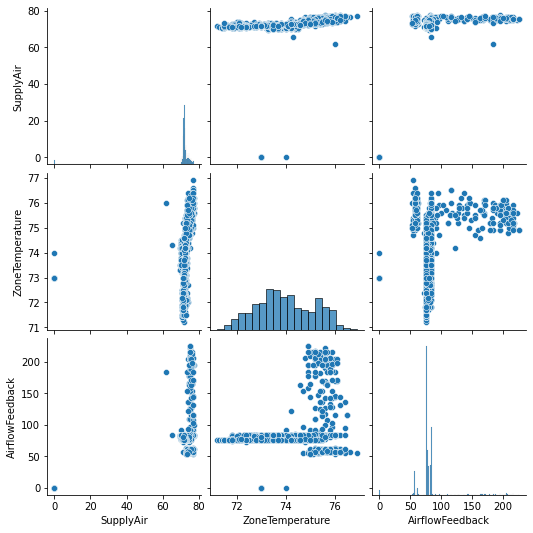

In [14]:
sampled_therma_df = thermafuser_df.sample(frac=1/10, replace=True)
#sampled_therma_df.shape
sns.pairplot(sampled_therma_df)

In [15]:
day_quarters = {0:'0-5', 1:'6-11', 2:'12-17', 3:'18-23'}
thermafuser_df['Day quarter'] = thermafuser_df['Timestamp'].map(lambda x: x.hour//6)
dummies = pd.get_dummies(thermafuser_df['Day quarter'])
thermafuser_df = pd.concat([thermafuser_df, dummies], axis=1)
thermafuser_df.rename(columns=day_quarters, inplace=True)
thermafuser_df.head()

,SupplyAir,Timestamp,ZoneTemperature,AirflowFeedback,Day quarter,0-5,6-11,12-17,18-23
0,75.199997,2018-07-11 14:15:00,74.699997,63.0,2,0,0,1,0
1,76.099998,2018-07-11 14:20:01,74.300003,61.0,2,0,0,1,0
2,75.900002,2018-07-11 14:25:01,74.900002,59.0,2,0,0,1,0
3,75.900002,2018-07-11 14:30:02,75.099998,76.0,2,0,0,1,0
4,75.699997,2018-07-11 14:35:04,75.599998,150.0,2,0,0,1,0


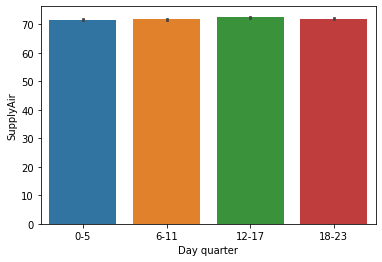

In [16]:
ax_supplyAir = sns.barplot(x='Day quarter', y='SupplyAir', data=thermafuser_df)
xticks_labels = [day_quarters[x] for x in ax_supplyAir.get_xticks()]
_ = ax_supplyAir.set_xticklabels(xticks_labels)

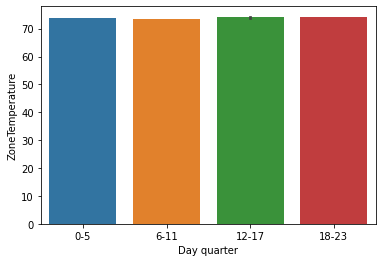

In [17]:
ax_zoneTemp = sns.barplot(x='Day quarter', y='ZoneTemperature', data=thermafuser_df)
xticks_labels = [day_quarters[x] for x in ax_zoneTemp.get_xticks()]
_ = ax_zoneTemp.set_xticklabels(xticks_labels)

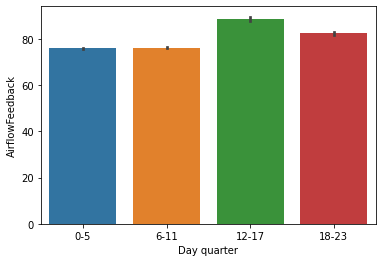

In [18]:
ax_airflowFdbck = sns.barplot(x='Day quarter', y='AirflowFeedback', data=thermafuser_df)
xticks_labels = [day_quarters[x] for x in ax_airflowFdbck.get_xticks()]
_ = ax_airflowFdbck.set_xticklabels(xticks_labels)

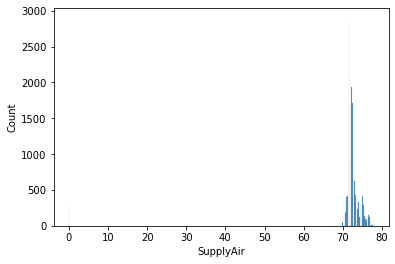

In [19]:
ax_supplyAir = sns.histplot(data=thermafuser_df, x='SupplyAir')

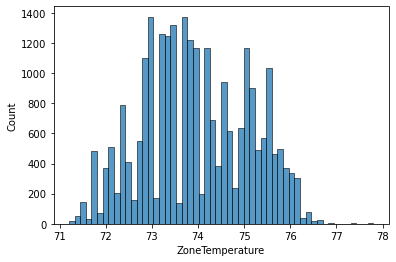

In [20]:
ax_zoneTemperature = sns.histplot(data=thermafuser_df, x='ZoneTemperature')

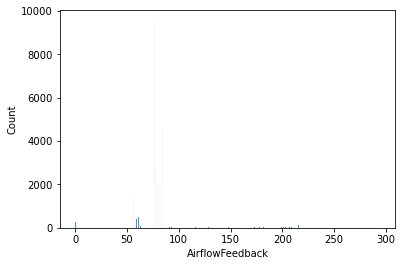

In [21]:
ax_airflowFdbck = sns.histplot(data=thermafuser_df, x='AirflowFeedback')

In [22]:
thermafuser_df.describe()

,SupplyAir,ZoneTemperature,AirflowFeedback,Day quarter,0-5,6-11,12-17,18-23
count,25330.000000,25330.000000,25330.000000,25330.000000,25330.000000,25330.00000,25330.000000,25330.000000
mean,71.928381,73.956816,80.868693,1.508962,0.247256,0.24769,0.253889,0.251165
std,7.626211,1.161022,25.631663,1.116607,0.431425,0.43168,0.435243,0.433692
min,0.000000,71.199997,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,71.699997,73.099998,76.000000,1.000000,0.000000,0.00000,0.000000,0.000000
50%,72.199997,73.800003,78.000000,2.000000,0.000000,0.00000,0.000000,0.000000
75%,73.300003,74.900002,82.000000,3.000000,0.000000,0.00000,1.000000,1.000000
max,77.800003,77.800003,294.000000,3.000000,1.000000,1.00000,1.000000,1.000000


In [23]:
print('First quarter: ' + str(thermafuser_df.loc[thermafuser_df['0-5'] == 1, ['0-5']].shape))
print('Second quarter: ' + str(thermafuser_df.loc[thermafuser_df['6-11'] == 1, ['0-5']].shape))
print('Third quarter: ' + str(thermafuser_df.loc[thermafuser_df['12-17'] == 1, ['0-5']].shape))
print('Fourth quarter: ' + str(thermafuser_df.loc[thermafuser_df['18-23'] == 1, ['0-5']].shape))

First quarter: (6263, 1)
Second quarter: (6274, 1)
Third quarter: (6431, 1)
Fourth quarter: (6362, 1)


## Train data

Based on the data and the task at hand, we will train a model using isolation forests

In [24]:
#thermafuser_df.drop(0, axis=0, inplace=True)
#thermafuser_df.drop('Day quarter', axis=1, inplace=True)
#thermafuser_df.drop('Timestamp', axis=1, inplace=True)
#thermafuser_df.head()

thermafuser_df_train = thermafuser_df[['AirflowFeedback', 'SupplyAir', 'ZoneTemperature', '0-5', '6-11', '12-17', '18-23']]

In [25]:
X_train, X_test = train_test_split(thermafuser_df_train, test_size=0.1)
X_train, X_crossVal = train_test_split(X_train, test_size=0.2)

X_train.reset_index(inplace=True, drop=True)
X_crossVal.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

print(X_train.shape)
print(X_crossVal.shape)
print(X_test.shape)

X_crossVal.head()

(18237, 7)
(4560, 7)
(2533, 7)


,AirflowFeedback,SupplyAir,ZoneTemperature,0-5,6-11,12-17,18-23
0,82.0,72.099998,73.199997,0,0,0,1
1,61.0,75.199997,75.900002,0,0,0,1
2,114.0,75.599998,75.599998,0,0,1,0
3,76.0,72.099998,73.800003,0,1,0,0
4,76.0,72.099998,73.000000,0,0,1,0


In [26]:
clf = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.05), max_features=1.0,
                     bootstrap=False, n_jobs=1, verbose=1)
clf.fit(X_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


IsolationForest(contamination=0.05, n_jobs=1, verbose=1)

## Evaluate the model

In [27]:
pred = clf.predict(X_crossVal[['SupplyAir', 'ZoneTemperature', 'AirflowFeedback', '0-5', '6-11', '12-17', '18-23']])
X_crossVal['anomaly'] = pred
outliers = X_crossVal.loc[X_crossVal['anomaly'] == -1]
outlier_index=list(outliers.index)
print(X_crossVal['anomaly'].value_counts())

 1    3907
-1     653
Name: anomaly, dtype: int64


In [28]:
X_crossVal.head()

,AirflowFeedback,SupplyAir,ZoneTemperature,0-5,6-11,12-17,18-23,anomaly
0,82.0,72.099998,73.199997,0,0,0,1,1
1,61.0,75.199997,75.900002,0,0,0,1,-1
2,114.0,75.599998,75.599998,0,0,1,0,1
3,76.0,72.099998,73.800003,0,1,0,0,1
4,76.0,72.099998,73.000000,0,0,1,0,1


In [29]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_crossVal[['SupplyAir', 'ZoneTemperature', 'AirflowFeedback']])

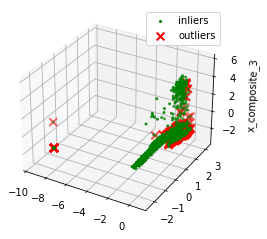

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_scaled[:, 0], X_scaled[:, 1], zs=X_scaled[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_scaled[outlier_index,0],X_scaled[outlier_index,1], X_scaled[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

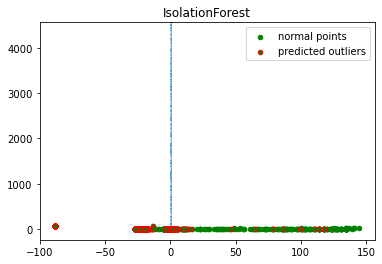

In [31]:
pca = PCA(2)
pca.fit(X_crossVal[['SupplyAir', 'ZoneTemperature', 'AirflowFeedback']])
res=pd.DataFrame(pca.transform(X_crossVal[['SupplyAir', 'ZoneTemperature', 'AirflowFeedback']]))
Z = np.array(res)
plt.title("IsolationForest")
plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

## Train model using time window

In [32]:
thermafuser_df_windowed = thermafuser_df.copy()
thermafuser_df_windowed.head()
thermafuser_df_windowed.shape

(25330, 9)

In [33]:
thermafuser_df_windowed['AirflowRoll'] = thermafuser_df['AirflowFeedback'].rolling(window=12).mean()
thermafuser_df_windowed['SupplyAirRoll'] = thermafuser_df['SupplyAir'].rolling(window=12).mean()
thermafuser_df_windowed['ZoneTemperatureRoll'] = thermafuser_df['ZoneTemperature'].rolling(window=12).mean()

thermafuser_df_windowed['0-5 Roll'] = thermafuser_df['0-5'].rolling(window=12).median()
thermafuser_df_windowed['6-11 Roll'] = thermafuser_df['6-11'].rolling(window=12).median()
thermafuser_df_windowed['12-17 Roll'] = thermafuser_df['12-17'].rolling(window=12).median()
thermafuser_df_windowed['18-23 Roll'] = thermafuser_df['18-23'].rolling(window=12).median()

In [34]:
thermafuser_df_windowed[:20]

,SupplyAir,Timestamp,ZoneTemperature,AirflowFeedback,Day quarter,0-5,6-11,12-17,18-23,AirflowRoll,SupplyAirRoll,ZoneTemperatureRoll,0-5 Roll,6-11 Roll,12-17 Roll,18-23 Roll
0,75.199997,2018-07-11 14:15:00,74.699997,63.0,2,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,76.099998,2018-07-11 14:20:01,74.300003,61.0,2,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,75.900002,2018-07-11 14:25:01,74.900002,59.0,2,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,75.900002,2018-07-11 14:30:02,75.099998,76.0,2,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,75.699997,2018-07-11 14:35:04,75.599998,150.0,2,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,76.099998,2018-07-11 14:40:03,75.199997,161.0,2,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,76.199997,2018-07-11 14:45:04,75.199997,80.0,2,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,76.199997,2018-07-11 14:50:04,75.199997,61.0,2,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,76.500000,2018-07-11 14:55:01,75.400002,57.0,2,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,76.400002,2018-07-11 15:00:00,75.400002,57.0,2,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
thermafuser_df_windowed = thermafuser_df_windowed[['AirflowRoll', 'SupplyAirRoll', 'ZoneTemperatureRoll', 
                                                  '0-5 Roll', '6-11 Roll', '12-17 Roll', '18-23 Roll']]
thermafuser_df_windowed = thermafuser_df_windowed.dropna()
thermafuser_df_windowed.head()
thermafuser_df_windowed.shape

(25319, 7)

In [36]:
X_train, X_test = train_test_split(thermafuser_df_windowed, test_size=0.1)
X_train, X_crossVal = train_test_split(X_train, test_size=0.2)

X_train.reset_index(inplace=True, drop=True)
X_crossVal.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

print(X_train.shape)
print(X_crossVal.shape)
print(X_test.shape)

X_crossVal.head()

(18229, 7)
(4558, 7)
(2532, 7)


,AirflowRoll,SupplyAirRoll,ZoneTemperatureRoll,0-5 Roll,6-11 Roll,12-17 Roll,18-23 Roll
0,78.333333,72.166665,74.125000,0.0,0.0,0.0,1.0
1,78.833333,71.991666,72.150000,0.0,1.0,0.0,0.0
2,79.000000,72.174999,73.758332,1.0,0.0,0.0,0.0
3,82.000000,71.716664,73.125000,0.0,1.0,0.0,0.0
4,59.500000,73.866669,75.450001,1.0,0.0,0.0,0.0


In [37]:
clf = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.05), max_features=1.0,
                     bootstrap=False, n_jobs=1, verbose=1)
clf.fit(X_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


IsolationForest(contamination=0.05, n_jobs=1, verbose=1)

## Evaluate the windowed model

In [38]:
pred = clf.predict(X_crossVal)
print(pred)
print(type(pred))

[ 1  1  1 ...  1 -1  1]
<class 'numpy.ndarray'>


In [39]:
X_crossVal['anomaly'] = pred
outliers = X_crossVal.loc[X_crossVal['anomaly'] == -1]
outlier_index=list(outliers.index)
print(X_crossVal['anomaly'].value_counts())

 1    4323
-1     235
Name: anomaly, dtype: int64


In [40]:
X_crossVal.head()

,AirflowRoll,SupplyAirRoll,ZoneTemperatureRoll,0-5 Roll,6-11 Roll,12-17 Roll,18-23 Roll,anomaly
0,78.333333,72.166665,74.125000,0.0,0.0,0.0,1.0,1
1,78.833333,71.991666,72.150000,0.0,1.0,0.0,0.0,1
2,79.000000,72.174999,73.758332,1.0,0.0,0.0,0.0,1
3,82.000000,71.716664,73.125000,0.0,1.0,0.0,0.0,1
4,59.500000,73.866669,75.450001,1.0,0.0,0.0,0.0,1


In [41]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_crossVal[['SupplyAirRoll', 'ZoneTemperatureRoll', 'AirflowRoll']])

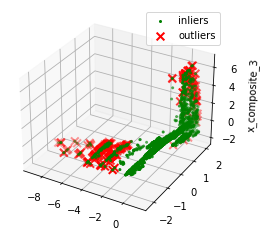

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_scaled[:, 0], X_scaled[:, 1], zs=X_scaled[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_scaled[outlier_index,0],X_scaled[outlier_index,1], X_scaled[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

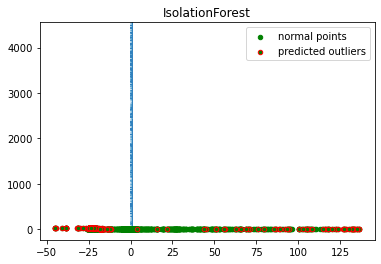

In [43]:
pca = PCA(2)
pca.fit(X_crossVal[['SupplyAirRoll', 'ZoneTemperatureRoll', 'AirflowRoll']])
res=pd.DataFrame(pca.transform(X_crossVal[['SupplyAirRoll', 'ZoneTemperatureRoll', 'AirflowRoll']]))
Z = np.array(res)
plt.title("IsolationForest")
plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()